In [2]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from tensorflow.keras.models import load_model


# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [3]:
path = r"D:\Ambis Kuliah\Semester 7\NAIST Internship\Breast Cancer Project\Program\Final Data for Model\train\cancer"

os.chdir(path)


mammography = []


with os.scandir(path) as files :
    for file in files :
        if file.name.endswith('.jpg'):
            mammography.append(file.name)
            
print(mammography[:15])

['A_1000_1.LEFT_CC_crop_0.jpg', 'A_1000_1.LEFT_MLO_crop_0.jpg', 'A_1000_1.RIGHT_CC_crop_0.jpg', 'A_1000_1.RIGHT_MLO_crop_0.jpg', 'A_1001_1.LEFT_CC_crop_0.jpg', 'A_1001_1.LEFT_MLO_crop_0.jpg', 'A_1001_1.RIGHT_CC_crop_0.jpg', 'A_1001_1.RIGHT_MLO_crop_0.jpg', 'A_1002_1.LEFT_CC_crop_0.jpg', 'A_1002_1.LEFT_MLO_crop_0.jpg', 'A_1002_1.RIGHT_CC_crop_0.jpg', 'A_1002_1.RIGHT_MLO_crop_0.jpg', 'A_1003_1.LEFT_CC_crop_0.jpg', 'A_1003_1.LEFT_MLO_crop_0.jpg', 'A_1003_1.RIGHT_CC_crop_0.jpg']


In [4]:
img = load_img(mammography[0], target_size=(224,224))
img = np.array(img)

print(img.shape)

(224, 224, 3)


In [5]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [6]:
x = preprocess_input(reshaped_img)

In [19]:
# load model
model=load_model(r"D:\Ambis Kuliah\Semester 7\NAIST Internship\Breast Cancer Project\Program\bcancer_model.h5")
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19_input (InputLaye  [(None, 224, 224, 3)]     0         
 r)                                                              
                                                                 
 conv2d_19 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_20 (Conv2D)          (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 108, 108, 64)      9280      
                                                                 
 conv2d_22 (Conv2D)          (None, 106, 106, 64)      36928 

In [21]:
def extract_features(file, model):
    img = load_img(file, target_size=(224,224))
    img = np.array(img) 
    reshaped_img = img.reshape(1,224,224,3) 
    
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [22]:
data={}

p = 'feat.pkl'

for mamph in mammography:
    try:
        feat = extract_features(mamph,model)
        data[mamph] = feat
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


In [23]:
filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))
feat.shape

(2732, 1, 2048)

In [24]:
feat = feat.reshape(-1,2048)
feat.shape

(2732, 2048)

Components before PCA: 2048
Components after PCA: 20


Text(0, 0.5, 'cumulative explained variance')

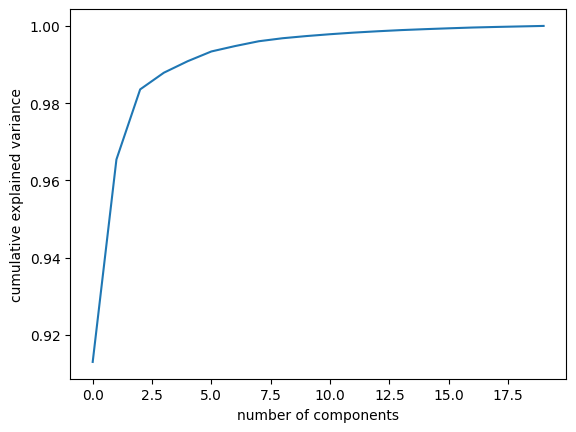

In [61]:
pca = PCA(n_components=20, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

pca = PCA().fit(x.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [68]:
kmeans = KMeans(n_clusters=15, random_state=22)
kmeans.fit(x)

C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=15, random_state=22)

In [69]:
kmeans.labels_

array([9, 6, 7, ..., 7, 2, 3])

In [70]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [71]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [72]:
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)


C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\

C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\breast-cancer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\

Elbow point (knee) at K = 28


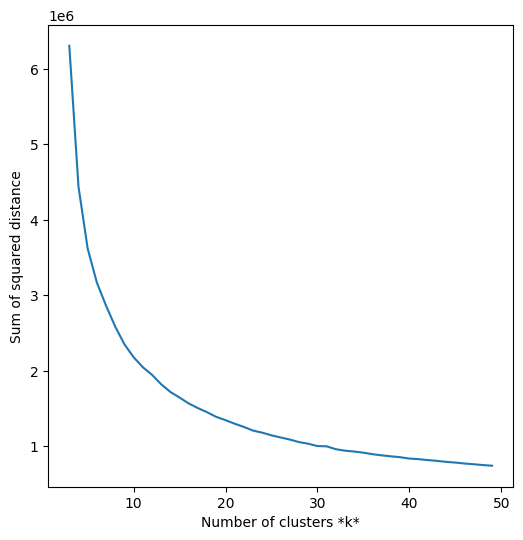

In [73]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

#elbow point otomatis
diff_wcss = np.diff(sse)
knee = np.argmax(diff_wcss) + 1

print("Elbow point (knee) at K =", knee)